In [1]:
import os
import json
from glob import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta

from google.cloud import bigquery
from google.oauth2 import service_account

pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#matplotlib 패키지 한글 깨짐 처리 시작
plt.rc('font', family='AppleGothic') #맥

df = pd.read_csv('ga4_data.csv')

/var/folders/mk/p5y6cznx60788rys6_dnljxm0000gn/T/ipykernel_23162/64509669.py:23: DtypeWarning: Columns (1,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ga4_data.csv')


In [2]:
# 전처리 
df['visitStartTime'] = pd.to_datetime(df['visitStartTime'])
df['totals_totalTransactionRevenue'] = df['totals_totalTransactionRevenue'].fillna(0)
df['hits_transaction_transactionRevenue'] = df['hits_transaction_transactionRevenue'].fillna(0)

def pad_with_zeros(string):
    """
    문자열의 길이가 19이 될 때까지 앞에 0을 추가하는 함수
    """
    # 문자열의 길이를 세기
    length = len(string)
    
    # 문자열의 길이가 20이 될 때까지 앞에 0을 추가
    while length < 19:
        string = '0' + string
        length += 1
    
    return string

df['fullVisitorId'] = df['fullVisitorId'].astype(str)
df['fullVisitorId'] = df['fullVisitorId'].apply(pad_with_zeros)

df.visitStartTime = (df.visitStartTime - timedelta(hours=8))
# df = df.assign(month = df.visitStartTime.dt.strftime('%Y-%m'))
# df = df.assign(date = df.visitStartTime.dt.strftime('%m-%d'))
# df = df.assign(day_name = df.visitStartTime.dt.weekday)

In [3]:
#vvip 와 plain
non_zero = df[df['totals_totalTransactionRevenue'] != 0]
indv = non_zero.groupby('fullVisitorId')['totals_totalTransactionRevenue'].sum().reset_index()
indv = indv.sort_values('totals_totalTransactionRevenue', ascending=False)
indv['revenue_pct'] = indv['totals_totalTransactionRevenue'].cumsum() / indv['totals_totalTransactionRevenue'].sum() * 100
indv['id_count'] = indv.groupby('fullVisitorId').cumcount() + 1
indv['id_pct'] = indv['id_count'].cumsum() / indv['id_count'].sum() * 100

vvip_ids = indv[indv['revenue_pct'] <= 90]['fullVisitorId'].unique()
plain_ids = indv[indv['revenue_pct'] > 90]['fullVisitorId'].unique()

가설2. : vvip 와 plain 고객은 웹사이트 접속해서 구매까지 걸리는 시간이 다를 것이다.

vvip 와 plain 고객은 오랫동안 고민하고 구매하는 신중한 고객인가? 고민하지 않고 결정을 신속하게 내리는 고객인가?

In [4]:
#df -- id, visitStartTime, hit_hour, hit_minute, eCommerce_action_type 컬럼을 사용.
#유저가 아무행동 하지 않아도 hit_hour, minute 은 찍힌다. 
time_df = df[['fullVisitorId', 'visitId', 'visitStartTime', 'hits_hour', 'hits_minute', 'hits_eCommerceAction_action_type', 'totals_totalTransactionRevenue']]

#전체 구매 고객 기준
time_df = time_df[time_df['totals_totalTransactionRevenue'] != 0]

# 에지 케이스. 한 세션 (30분) 동안 장바구니 보면서 고민만 하다가 다음 세션으로 넘어가서 구매를 결정한 고객도 있을 것이다.
# 세션의 마지막 hit_hour, hit_minute 가 그 다음 세션의 hit_hour, hit_minute 과 1분이상 차이가 나지 않으면 하나의 세션으로 간주한다. 
# 세션을 visitStartTime 으로 정렬하고, 그 전 세션과 hit_hour, minute 차이를 구한뒤 1분미만 차이가 나면 하나의 세션으로 계산한다. 

# hits_hour, hits_minute 을 dt.time 으로 바꾼다
time_df['time_str'] = time_df['hits_hour'].astype(str).str.zfill(2) + ':' + time_df['hits_minute'].astype(str).str.zfill(2)
time_df['time'] = pd.to_datetime(time_df['time_str'], format='%H:%M').dt.time
time_df.drop(columns=['time_str'], inplace=True)

#day 컬럼을 만들어준다
time_df['day'] = time_df['visitStartTime'].dt.date

#  "first_hits", "last_hits" 컬럼을 만든다.
time_df['first_hits'] = time_df.groupby('visitId')['time'].transform('min')
time_df['last_hits'] = time_df.groupby('visitId')['time'].transform('max')
time_df = time_df.drop_duplicates(subset=['visitId'])

#visitStartTime 으로 정렬하고, 그 전 세션의 last_hits와 차이를 구한뒤 1분미만 차이가 나면 하나의 세션으로 계산한다.
result = 0
result_lst = []
for id_name, id_data in time_df.groupby(['fullVisitorId', 'day']):
    id_data = id_data.sort_values('visitStartTime')
    num = id_data['visitId'].nunique()
    if num > 1:
        for index, (visit_id, visit_data) in enumerate(id_data.groupby('visitId')):
            if index == 0:
                previous_last_hit = visit_data['last_hits'].values[0]
            else:
                current_first_hit = visit_data['first_hits'].values[0]
                minutes_diff = (current_first_hit.hour - previous_last_hit.hour) * 60 + (current_first_hit.minute - previous_last_hit.minute)
                # 1분 이하면 increment
                if minutes_diff <= 1:
                    result += 1
                    result_lst.append(visit_id)
                    result_lst.append(prev_id)
                previous_last_hit = visit_data['last_hits'].values[0]
                prev_id = visit_id
                
print(f'고민을 정말 많이한 고객의 수 {result}명')
#이 한명 보려고 내가 2시간을 썻나...
print(f'합칠 세션 id {result_lst}')

#세션을 병합
df.loc[df['visitId'] == 1496018608, 'visitID'] = 1491543261
time_df.loc[time_df['visitId'] == 1496018608, 'visitID'] = 1491543261

고민을 정말 많이한 고객의 수 1명
합칠 세션 id [1491543261, 1496018608]


In [5]:
#한 세션의 시작 시간 (처음 hits_hour, hits_minute) 과 끝나는 시간 (마지막 hits_hour, hits_minute) 의 차이를 구하고 고객 id 별 평균을 구한다.
time_df = df[['fullVisitorId', 'visitId', 'visitStartTime', 'hits_hour', 'hits_minute', 'hits_eCommerceAction_action_type', 'totals_totalTransactionRevenue']]

import warnings
warnings.filterwarnings(action='ignore')

#first_hit, last_hit
def get_time(time_df):
    time_df['time_str'] = time_df['visitStartTime'].dt.strftime('%Y-%m-%d') + " " + time_df['hits_hour'].astype(str).str.zfill(2) + ':' + time_df['hits_minute'].astype(str).str.zfill(2)
    time_df['time'] = pd.to_datetime(time_df['time_str'], format='%Y-%m-%d %H:%M')
    time_df.drop(columns=['time_str'], inplace=True)
    time_df = time_df.groupby(['fullVisitorId', 'visitId'])['time'].agg(['min', 'max']).reset_index()
    time_df.rename(columns={'min': 'first_hit'}, inplace=True)
    time_df.rename(columns={'max': 'last_hit'}, inplace=True)
    time_df['diff_in_mins'] = (time_df['last_hit'] - time_df['first_hit']).dt.total_seconds() / 60
    
    #평균
    mean = time_df['diff_in_mins'].mean()
    print(f'평균 체류 시간 {mean} 분')


#비구매 고객 기준
norev_df = time_df[time_df['totals_totalTransactionRevenue'] == 0]
print('비구매')
get_time(norev_df)
#구매 고객 기준
rev_df = time_df[time_df['totals_totalTransactionRevenue'] != 0]
print('구매')
get_time(rev_df)

비구매
평균 체류 시간 3.6025878477723197 분
구매
평균 체류 시간 17.165484197917625 분


In [6]:
dic = {'label':['비구매', '구매'], 'value':[norev_df, rev_df]}
pd.DataFrame(dic).to_csv('lingering_time.csv', index=False)

vip
평균 체류 시간 22.57777179763186 분
중간값 체류 시간 18.0 분


<Axes: xlabel='diff_in_mins', ylabel='Count'>

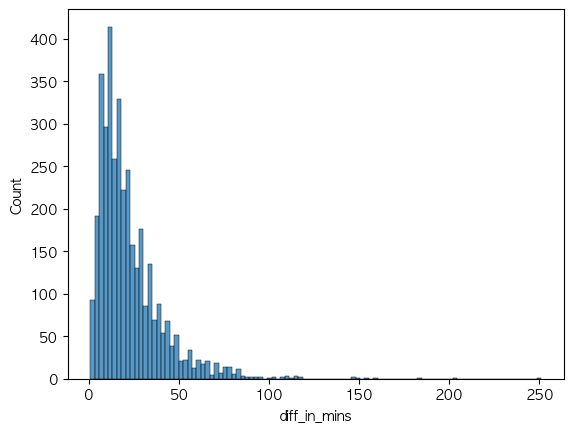

In [8]:
#vvips
time_df = df[['fullVisitorId', 'visitId', 'visitStartTime', 'hits_hour', 'hits_minute', 'hits_eCommerceAction_action_type', 'totals_totalTransactionRevenue']]
vip_time_df = time_df[time_df['fullVisitorId'].isin(vvip_ids)]
vip_time_df = vip_time_df[vip_time_df['totals_totalTransactionRevenue'] != 0]

#first_hit, last_hit
vip_time_df['time_str'] = vip_time_df['visitStartTime'].dt.strftime('%Y-%m-%d') + " " + vip_time_df['hits_hour'].astype(str).str.zfill(2) + ':' + vip_time_df['hits_minute'].astype(str).str.zfill(2)
vip_time_df['time'] = pd.to_datetime(vip_time_df['time_str'], format='%Y-%m-%d %H:%M')
vip_time_df.drop(columns=['time_str'], inplace=True)
vip_time_df = vip_time_df.groupby(['visitId'])['time'].agg(['min', 'max']).reset_index()
vip_time_df.rename(columns={'min': 'first_hit'}, inplace=True)
vip_time_df.rename(columns={'max': 'last_hit'}, inplace=True)
vip_time_df['diff_in_mins'] = (vip_time_df['last_hit'] - vip_time_df['first_hit']).dt.total_seconds() / 60

#평균
mean = vip_time_df['diff_in_mins'].mean()
median = vip_time_df['diff_in_mins'].median()
print('vip')
print(f'평균 체류 시간 {mean} 분')
print(f'중간값 체류 시간 {median} 분')

#그리기
sns.histplot(vip_time_df, x='diff_in_mins')

plain
평균 체류 시간 14.347253363228699 분
중간값 체류 시간 11.0 분


<Axes: xlabel='diff_in_mins', ylabel='Count'>

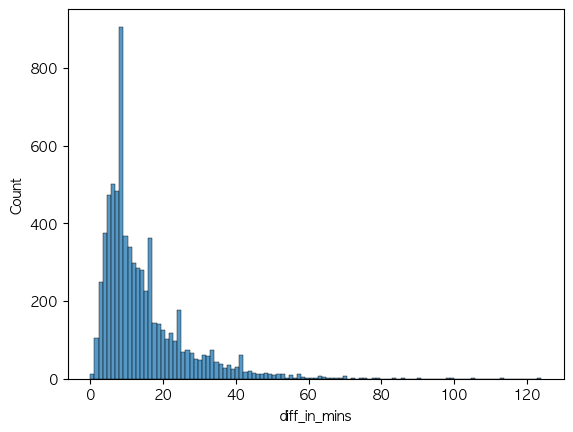

In [9]:
#plain
time_df = df[['fullVisitorId', 'visitId', 'visitStartTime', 'hits_hour', 'hits_minute', 'hits_eCommerceAction_action_type', 'totals_totalTransactionRevenue']]
plain_time_df = time_df[time_df['fullVisitorId'].isin(plain_ids)]

#전체 구매 고객 기준
plain_time_df = plain_time_df[plain_time_df['totals_totalTransactionRevenue'] != 0]

#first_hit, last_hit
plain_time_df['time_str'] = plain_time_df['visitStartTime'].dt.strftime('%Y-%m-%d') + " " + plain_time_df['hits_hour'].astype(str).str.zfill(2) + ':' + plain_time_df['hits_minute'].astype(str).str.zfill(2)
plain_time_df['time'] = pd.to_datetime(plain_time_df['time_str'], format='%Y-%m-%d %H:%M')
plain_time_df.drop(columns=['time_str'], inplace=True)
plain_time_df = plain_time_df.groupby(['visitId'])['time'].agg(['min', 'max']).reset_index()
plain_time_df.rename(columns={'min': 'first_hit'}, inplace=True)
plain_time_df.rename(columns={'max': 'last_hit'}, inplace=True)
plain_time_df['diff_in_mins'] = (plain_time_df['last_hit'] - plain_time_df['first_hit']).dt.total_seconds() / 60

#평균
mean = plain_time_df['diff_in_mins'].mean()
median = plain_time_df['diff_in_mins'].median()
print('plain')
print(f'평균 체류 시간 {mean} 분')
print(f'중간값 체류 시간 {median} 분')

#그리기
sns.histplot(plain_time_df, x='diff_in_mins')

vvip 는 평균 22분, plain 은 14분. 전체 고객은 그 사이인 17분. 이 차이는 유의미한 차이일까? 쿠팡의 한달 평균 체류시간은 6분이다. 이에 비하면 17분은 정말 긴데, 그 이유를 전체적으로 찾아보자.

http://m.apparelnews.co.kr/news/news_view/?idx=187387

vvip 는 왜 오래 머무를까?

vvip 는 오래 고민하는 걸까? 

아니면 vvip 는 다양한 카테고리 상품을 보고 대량 구매를 하기때문에 오래 걸리는 걸까?

In [10]:
# vvip = pd.DataFrame(vvip_ids)
# vvip.columns = ['vvip_id']
# vvip.to_csv('vvip.csv', index=False)
# plain = pd.DataFrame(plain_ids)
# plain.columns = ['plain_id']
# plain.to_csv('plain.csv', index=False)

# vvip 의 세션당 평균 구매 횟수 vs plain
# vvip 의 세션당 장바구니에 담는 상품 종류 개수 vs plain

# vvip 의 세션의 개수를 보기 -- 총량 vs 한번 들어왔을때 -- 이 사람들이 한번사고 끝
# vvip 의 상품카테고리를 어떻게 구매하는지 보기 -- 하나의 세션에 사는 카테고리의 개수

#일단 구매 vs 비구매
# count() 로 하면 웹사이트에 다시 들어오는 것도 횟수로 계산한다.
# nunique() 로 하면 접속한 웹사이트 페이지 고유 값으로 계산된다. 
n1 = round(df[df['totals_totalTransactionRevenue'] == 0].groupby('fullVisitorId')['visitId'].count().mean(), 1)
print(f'비구매 고객 세션 개수 {n1}')

n2 = round(df[df['totals_totalTransactionRevenue'] != 0].groupby('fullVisitorId')['visitId'].count().mean(), 1)
print(f'구매 고객 세션 개수 {n2}')

vip = df[df['fullVisitorId'].isin(vvip_ids)]
n3 = round(vip.groupby('fullVisitorId')['visitId'].count().mean(), 1)
print(f'vvip 세션 개수 {n3}')

plain = df[df['fullVisitorId'].isin(plain_ids)]
n4 = round(plain.groupby('fullVisitorId')['visitId'].count().mean(), 1)
print(f'plain 세션 개수 {n4}')

비구매 고객 세션 개수 8.4
구매 고객 세션 개수 40.9
vvip 세션 개수 114.8
plain 세션 개수 47.3


In [11]:
dic = {'label': ['비구매', '구매','0군집', '그외'], 'value': [n1, n2, n3, n4]}
pd.DataFrame(dic).to_csv('session_num.csv', index=False)

vvip는 압도적으로 더 많은 활동을 한다.

In [12]:
# 가설 -- vvip 는 사는 제품이 다양해서 오래 걸리는 것이다. 

# 장바구니 추가 3을 횟수를 카운트. hits_eCommerceAction_action_type
# 장바구니 추가로 제품 카테고리의 다양성을 추측할수 있다.

add_cart = vip[vip['hits_eCommerceAction_action_type'] == 3]
vip_add_cart = add_cart.groupby('visitId')['hits_eCommerceAction_action_type'].count().mean()

add_cart = plain[plain['hits_eCommerceAction_action_type'] == 3]
plain_add_cart = add_cart.groupby('visitId')['hits_eCommerceAction_action_type'].count().mean()

print(f'vip 평균 장바구니 추가 횟수 {round(vip_add_cart, 1)}, plain 평균 장바구니 추가 횟수 {round(plain_add_cart, 1)}')
print(f'vip 가 {round(vip_add_cart, 1) // round(plain_add_cart, 1)} 배 많음')

vip 평균 장바구니 추가 횟수 4.7, plain 평균 장바구니 추가 횟수 2.2
vip 가 2.0 배 많음


In [13]:
dic = {'label': ['군집0', '그외'], 'value': [vip_add_cart, plain_add_cart]}
pd.DataFrame(dic).to_csv('add_cart_num.csv', index=False)

In [14]:
# vvip 랜딩 페이지 확인
vip = df[df['fullVisitorId'].isin(vvip_ids)]
vip = vip[vip['totals_totalTransactionRevenue'] != 0]
total = vip.sort_values('hits_hitNumber').groupby('visitId')['hits_page_pageTitle'].head(1).value_counts().sum()
first_page = vip.groupby('visitId')['hits_page_pageTitle'].head(1).value_counts() / total
first_page = round(first_page * 100, 2)
first_page.head(5)

hits_page_pageTitle
Home                                                    12.17
Shopping Cart                                           11.82
Men's T-Shirts | Apparel | Google Merchandise Store      3.58
The Google Merchandise Store - Log In                    3.18
Men's Outerwear | Apparel | Google Merchandise Store     3.10
Name: count, dtype: float64

In [16]:
first_page.to_csv('target_landing_page.csv', index=True)

In [18]:
# vvip 세션 종료율 먼저 확인
# hits_page_pageTitile
total = vip.sort_values('hits_hitNumber').groupby('visitId')['hits_page_pageTitle'].tail(1).value_counts().sum()
last_page = vip.groupby('visitId')['hits_page_pageTitle'].tail(1).value_counts() / total
last_page = round(last_page * 100, 2)
last_page.head(10)
# 로그인페이지에서 관둔 사람들이 7 % 로 많음.

hits_page_pageTitle
Checkout Confirmation                                       21.72
Shopping Cart                                               14.67
Payment Method                                              11.11
Checkout Review                                              8.85
Checkout Your Information                                    8.45
The Google Merchandise Store - Log In                        3.85
The Google Merchandise Store - My Account                    3.61
Home                                                         2.72
Notebooks & Journals | Office | Google Merchandise Store     1.35
Store search results                                         1.32
Name: count, dtype: float64

In [19]:
last_page.to_csv('target_last_page.csv', index=True)

In [20]:
# 체류시간은 대부분 1분 미만인데 초가 없어서 구하지 못함. 
# hits_page_pageTitile 기준, 
vip['time_str'] = vip['visitStartTime'].dt.strftime('%Y-%m-%d') + " " + vip['hits_hour'].astype(str).str.zfill(2) + ':' + vip['hits_minute'].astype(str).str.zfill(2)
vip['time'] = pd.to_datetime(vip['time_str'], format='%Y-%m-%d %H:%M')
vip.drop(columns=['time_str'], inplace=True)
temp = vip.sort_values('time', ascending=True)

temp['time_diff'] = temp.groupby(['visitId'])['time'].diff()
# Group the DataFrame by webpage and calculate the average time spent on each webpage
time_diff = temp.groupby('hits_page_pageTitle')['time_diff'].mean().reset_index()
time_diff.sort_values('time_diff', inplace=True, ascending=False)
time_diff


,hits_page_pageTitle,time_diff
447,Shopping Cart - https://shop.googlemerchandise...,0 days 00:08:00
525,The Google Merchandise Store/UFO Bluetooth Wat...,0 days 00:04:00
32,Android Men's Engineer Short Sleeve Tee Charcoal,0 days 00:01:56.470588235
512,The Google Merchandise Store/Plastic Sliding F...,0 days 00:01:55.384615384
424,Potencia y Cargadores | Electrónica | Google t...,0 days 00:01:50
...,...,...
357,Google botella de agua de 22 oz,0 days 00:00:00
514,The Google Merchandise Store/PowerClip Lightni...,0 days 00:00:00
513,The Google Merchandise Store/Pop-a-Point Crayon,0 days 00:00:00
0,"10,400mAh cargador de alta capacidad de Google",0 days 00:00:00


In [21]:
time_diff.to_csv('target_time_diff.csv', index=False)

In [22]:
# 홈 페이지의 평균 체류시간을 확인
# Home                                                               
# The Google Merchandise Store - Log In
# The Google Merchandise Store - My Account                               
# Shopping Cart                                                                                                                                                    
# Payment Method  
# Checkout Confirmation 
# 의 순서로 보고
time_spent = vip.sort_values('hits_hitNumber')
time_spent['time_spent'] = time_spent.groupby(['visitId'])['time'].diff()

result = pd.DataFrame(columns=['page_title', 'avg_time_spent'])
lst = ["Checkout Confirmation", "Checkout Review", "Payment Method", "Shopping Cart", "The Google Merchandise Store - My Account", "The Google Merchandise Store - Log In", "Store search results","Home"]                                                            
for i, page in enumerate(lst):
    time = time_spent[time_spent['hits_page_pageTitle'] == page]['time_spent'].mean()
    new_row = {'page_title' : page, 'time_spent' : time}
    result = pd.concat([pd.DataFrame([[page,time]], columns=result.columns), result], ignore_index=True)

result

,page_title,avg_time_spent
0,Home,0 days 00:00:43.416345142
1,Store search results,0 days 00:00:17.460518003
2,The Google Merchandise Store - Log In,0 days 00:00:40.691823899
3,The Google Merchandise Store - My Account,0 days 00:00:55.622732769
4,Shopping Cart,0 days 00:00:24.650588311
5,Payment Method,0 days 00:00:57.075310748
6,Checkout Review,0 days 00:01:07.720674774
7,Checkout Confirmation,0 days 00:00:21.778310365


In [24]:
result.to_csv('page_avg_using_time.csv', index=False)

In [96]:
# 이탈 -- totals.bounce -- 전부 null 값
bounce = vip.sort_values('hits_hitNumber')
temp = bounce.groupby(['hits_page_pageTitle'])['totals_bounces'].count().reset_index()
temp.sort_values('totals_bounces', ascending=False)

,hits_page_pageTitle,totals_bounces
0,"10,400mAh cargador de alta capacidad de Google",0
391,Men's Softshell Jacket Black/Grey,0
393,Men's Weatherblock Shell Jacket Black,0
394,Men's-Outerwear,0
395,Men's-Performance Wear,0
...,...,...
198,Google Men's Lightweight Microfleece Jacket Black,0
199,Google Men's Long & Lean Tee Charcoal,0
200,Google Men's Long & Lean Tee Grey,0
201,Google Men's Long Sleeve Baseball Raglan Cranb...,0


Payment Method 페이지에서 11% 가 세션을 종료. 다음 액션까지 평균 57초의 체류시간.

Checkout Review 페이지에서 9% 가 세션을 종료. 다음 액션까지 평균 1분 7초의 체류시간.


In [25]:
# The Google Merchandise Store - Home --> Log In --> Shopping Cart --> payment method --> checkout Review --> Checkout Confirmation 이 정상적인 흐름이라고 생각함.
# vip 잔존률 (세션 기준)
vip = df[df['fullVisitorId'].isin(vvip_ids)]
vip = vip[vip['totals_totalTransactionRevenue'] != 0]

selected = vip.groupby('visitId').filter(lambda x: ("Home" in x['hits_page_pageTitle'].values))
home = selected['visitId'].count()

selected = selected.groupby('visitId').filter(lambda x: ("The Google Merchandise Store - Log In" in x['hits_page_pageTitle'].values))
login = selected['visitId'].count()

selected = selected.groupby('visitId').filter(lambda x: ("Shopping Cart" in x['hits_page_pageTitle'].values))
cart = selected['visitId'].count()

selected = selected.groupby('visitId').filter(lambda x: ("Payment Method" in x['hits_page_pageTitle'].values))
payment = selected['visitId'].count()

selected = selected.groupby('visitId').filter(lambda x: ("Checkout Review" in x['hits_page_pageTitle'].values))
review = selected['visitId'].count()

selected = selected.groupby('visitId').filter(lambda x: ("Checkout Confirmation" in x['hits_page_pageTitle'].values))
confirmation = selected['visitId'].count()

# 퍼널 분석 시각화
result = pd.DataFrame(columns=['stage', 'number'])
stages =["Home", "Log-in", "Shopping Cart", "Payment Method", "Checkout Review", "Checkout Confirmation"]
numbers =[home, login, cart, payment, review, confirmation]

from plotly import graph_objects as go

fig = go.Figure(go.Funnel(
    y = stages,
    x = numbers))

fig.show()

In [28]:
stages =["Home", "Log-in", "Shopping Cart", "Payment Method", "Checkout Review", "Checkout Confirmation"]
numbers =[home, login, cart, payment, review, confirmation]
dic = {'label': stages, 'val': numbers}
pd.DataFrame(dic).to_csv('target_funnel.csv', index=False)

vip 거의 모두 정상적인 흐름을 따른다.

In [119]:
# plain 은?
plain = df[df['fullVisitorId'].isin(plain_ids)]
plain = plain[plain['totals_totalTransactionRevenue'] != 0]

selected = plain.groupby('visitId').filter(lambda x: ("Home" in x['hits_page_pageTitle'].values))
home = selected['visitId'].count()

selected = selected.groupby('visitId').filter(lambda x: ("The Google Merchandise Store - Log In" in x['hits_page_pageTitle'].values))
login = selected['visitId'].count()

selected = selected.groupby('visitId').filter(lambda x: ("Shopping Cart" in x['hits_page_pageTitle'].values))
cart = selected['visitId'].count()

selected = selected.groupby('visitId').filter(lambda x: ("Payment Method" in x['hits_page_pageTitle'].values))
payment = selected['visitId'].count()

selected = selected.groupby('visitId').filter(lambda x: ("Checkout Review" in x['hits_page_pageTitle'].values))
review = selected['visitId'].count()

selected = selected.groupby('visitId').filter(lambda x: ("Checkout Confirmation" in x['hits_page_pageTitle'].values))
confirmation = selected['visitId'].count()

# 퍼널 분석 시각화
result = pd.DataFrame(columns=['stage', 'number'])
stages =["Home", "Log-in", "Shopping Cart", "Payment Method", "Checkout Review", "Checkout Confirmation"]
numbers =[home, login, cart, payment, review, confirmation]

from plotly import graph_objects as go

fig = go.Figure(go.Funnel(
    y = stages,
    x = numbers))

fig.show()

plain 고객 또한 마찬가지.

In [29]:
# 비구매 고객은
nonzero = df[df['totals_totalTransactionRevenue'] == 0]

selected = nonzero.groupby('visitId').filter(lambda x: ("Home" in x['hits_page_pageTitle'].values))
home = selected['visitId'].count()

selected = selected.groupby('visitId').filter(lambda x: ("The Google Merchandise Store - Log In" in x['hits_page_pageTitle'].values))
login = selected['visitId'].count()

selected = selected.groupby('visitId').filter(lambda x: ("Shopping Cart" in x['hits_page_pageTitle'].values))
cart = selected['visitId'].count()

selected = selected.groupby('visitId').filter(lambda x: ("Payment Method" in x['hits_page_pageTitle'].values))
payment = selected['visitId'].count()

selected = selected.groupby('visitId').filter(lambda x: ("Checkout Review" in x['hits_page_pageTitle'].values))
review = selected['visitId'].count()

selected = selected.groupby('visitId').filter(lambda x: ("Checkout Confirmation" in x['hits_page_pageTitle'].values))
confirmation = selected['visitId'].count()

# 퍼널 분석 시각화
result = pd.DataFrame(columns=['stage', 'number'])
stages =["Home", "Log-in", "Shopping Cart", "Payment Method", "Checkout Review", "Checkout Confirmation"]
numbers =[home, login, cart, payment, review, confirmation]

from plotly import graph_objects as go

fig = go.Figure(go.Funnel(
    y = stages,
    x = numbers))

fig.show()

In [31]:
stages =["Home", "Log-in", "Shopping Cart", "Payment Method", "Checkout Review", "Checkout Confirmation"]
numbers =[home, login, cart, payment, review, confirmation]
dic = {'label': stages, 'val': numbers}
pd.DataFrame(dic).to_csv('nonrev_funnel.csv', index=False)

구매고객의 경우 정상적인 흐름으로 구매가 이루어지지만, 비구매 고객의 경우 로그인을 안하고 이탈하거나(log-in), 결제를 하지않고 (payment method) 이탈해버린다. 

In [19]:
#어느 페이지 혹은 어느 제품에서 멈춰있던 체류시간이 긴지?
# 쿠팡은 결제까지 6분이 걸린다. 22분이 걸리는 이유가 장바구니를 너무 많이 담아서 그런거면 오케이. 그렇지 않다면 결제 전까지 걸리는 부분이 있는것!

# vip 장바구니 추가하는 시간 vs 추가 다하고 결제하는 시간 보기 -- 'hits_page_pageTitle'
# 처음 접속 시간 부터 마지막 장바구니 시간 vs 마지막 장바구니에서 결제 페이지까지의 시간
# visitStartTime -- vip["Shopping Cart"] vs vip["payment method"] -- vip['checkout confirmation]
vip = df[df['fullVisitorId'].isin(vvip_ids)]
vip = vip[vip['totals_totalTransactionRevenue'] != 0]

vip['time_str'] = vip['visitStartTime'].dt.strftime('%Y-%m-%d') + " " + vip['hits_hour'].astype(str).str.zfill(2) + ':' + vip['hits_minute'].astype(str).str.zfill(2)
vip['hit_time'] = pd.to_datetime(vip['time_str'], format='%Y-%m-%d %H:%M')
vip.drop(columns=['time_str'], inplace=True)

# 마지막 장바구니 히트 타임
last_shopping_cart = vip[vip['hits_page_pageTitle'] == 'Shopping Cart'].groupby('visitId')['hit_time'].agg('max').reset_index()
last_shopping_cart.rename(columns={'hit_time': 'last_cart_time'}, inplace=True)

# 맨 처음 시각 - 마지막 장바구니 히트 타임
first_visit = vip[vip['hits_page_pageTitle'] == 'Shopping Cart'].groupby('visitId')['hit_time'].agg('min').reset_index()
first_visit.rename(columns={'hit_time': 'first_visit_time'}, inplace=True)

# checkout confirmation 히트 타임
checkout_time = vip[vip['hits_page_pageTitle'] == 'Checkout Confirmation'].groupby('visitId')['hit_time'].agg('max').reset_index()
checkout_time.rename(columns={'hit_time': 'checkout_time'}, inplace=True)

# 처음 시각 - 마지막 장바구니
cart_time = first_visit.merge(last_shopping_cart, on='visitId', how='left')
cart_time = cart_time.merge(checkout_time, on='visitId', how='left')
cart_time['cart_diff'] = cart_time['last_cart_time'] - cart_time['first_visit_time']
cart_time['checkout_diff'] = cart_time['checkout_time'] - cart_time['last_cart_time']

mean = cart_time['cart_diff'].mean()
max_time = cart_time['cart_diff'].max()
print(f'vip 장바구니 담는 평균 시간: {mean}, 최대 시간: {max_time}')

mean = cart_time['checkout_diff'].mean()
max_time = cart_time['checkout_diff'].max()
print(f'vip 체크아웃 평균 시간: {mean}, 최대 시간: {max_time}')

vip 장바구니 담는 평균 시간: 0 days 00:12:13.290218270, 최대 시간: 0 days 03:12:00
vip 체크아웃 평균 시간: 0 days 00:04:32.328840970, 최대 시간: 0 days 00:41:00


In [15]:
#리텐션니어링 확인

218        3
322        3
435        3
471        3
473        3
          ..
2464570    3
2464817    3
2464835    3
2464845    3
2464862    3
Name: hits_eCommerceAction_action_type, Length: 56161, dtype: int64

In [22]:
len(plain_ids)

6796

In [23]:
df[df['fullVisitorId'].isin(plain_ids)].shape[0]

321492